# PDP & ICE plots for a DAI Model

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from h2oai_client import Client, ModelParameters, InterpretParameters
from sklearn.model_selection import train_test_split

# Download, explore, and prepare UCI credit card default data
UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables:

* LIMIT_BAL: Amount of given credit (NT dollar)
* SEX: 1 = male; 2 = female
* EDUCATION: 1 = graduate school; 2 = university; 3 = high school; 4 = others
* MARRIAGE: 1 = married; 2 = single; 3 = others
* AGE: Age in years
* PAY_0, PAY_2 - PAY_6: History of past payment; PAY_0 = the repayment status in September, 2005; PAY_2 = the repayment status in August, 2005; ...; PAY_6 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
* BILL_AMT1 - BILL_AMT6: Amount of bill statement (NT dollar). BILL_AMNT1 = amount of bill statement in September, 2005; BILL_AMT2 = amount of bill statement in August, 2005; ...; BILL_AMT6 = amount of bill statement in April, 2005.
* PAY_AMT1 - PAY_AMT6: Amount of previous payment (NT dollar). PAY_AMT1 = amount paid in September, 2005; PAY_AMT2 = amount paid in August, 2005; ...; PAY_AMT6 = amount paid in April, 2005.

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005.

# Import data and clean
The credit card default data is available as an .xls file. Pandas reads .xls files automatically, so it's used to load the credit card default data and give the prediction target a shorter name: DEFAULT_NEXT_MONTH.

In [2]:
#Import XLS file
path = 'data/default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1)

#Remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'})

# Helper function for recoding values in the UCI credit card default data
This simple function maps longer, more understandable character string values from the UCI credit card default data dictionary to the original integer values of the input variables found in the dataset. 

In [3]:
def recode_cc_data(frame):
    
    """ Recodes numeric categorical variables into categorical character variables
    with more transparent values. 
    
    Args:
        frame: Pandas DataFrame version of UCI credit card default data.
        
    Returns: 
        Pandas DataFrame with recoded values.
        
    """
    
    #Define recoded values
    sex_dict = {1:'male', 2:'female'}
    education_dict = {0:'other', 1:'graduate school', 2:'university', 3:'high school', 
                      4:'other', 5:'other', 6:'other'}
    marriage_dict = {0:'other', 1:'married', 2:'single', 3:'divorced'}
    pay_dict = {-2:'no consumption', -1:'pay duly', 0:'use of revolving credit', 1:'1 month delay', 
                2:'2 month delay', 3:'3 month delay', 4:'4 month delay', 5:'5 month delay', 6:'6 month delay', 
                7:'7 month delay', 8:'8 month delay', 9:'9+ month delay'}
    
    #Recode values using Pandas apply() and anonymous function
    frame['SEX'] = frame['SEX'].apply(lambda i: sex_dict[i])
    frame['EDUCATION'] = frame['EDUCATION'].apply(lambda i: education_dict[i])    
    frame['MARRIAGE'] = frame['MARRIAGE'].apply(lambda i: marriage_dict[i]) 
    for name in frame.columns:
        if name in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
            frame[name] = frame[name].apply(lambda i: pay_dict[i])            
                
    return frame

data = recode_cc_data(data)

# Display descriptive statistics for numeric variables

In [4]:
data.describe()

,ID,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,35.485500,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,9.217904,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,21.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,28.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,34.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,41.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,79.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


# Write train and test sets from client to DAI server disk for later use

In [34]:
train_path = "data/credit_train.csv"
test_path ="data/credit_test.csv"
if not (os.path.isfile(train_path) and os.path.isfile(test_path)):
    train_pd, test_pd = train_test_split(data, test_size=0.3) #Split credticard dataset into train/test
    train_pd.to_csv(path_or_buf="data/credit_train.csv", index=False) #Write train set to csv
    test_pd.to_csv(path_or_buf="data/credit_test.csv", index=False) #Write test set to csv
else:
    train_pd = pd.read_csv("data/credit_train.csv")
    test_pd = pd.read_csv("data/credit_test.csv")

# Connect to DAI Server

In [6]:
ip = 'localhost'
username = 'username'
password = 'password'
h2oai = Client(address = 'http://' + ip + ':12345', username = username, password = password)

# Upload data to DAI Server

In [7]:
cwd = os.getcwd()
train_path_dai = cwd+"/data/credit_train.csv" #DAI needs absolute path
test_path_dai = cwd+"/data/credit_test.csv"  #DAI needs absolute path
train = h2oai.create_dataset_sync(train_path_dai)
test = h2oai.create_dataset_sync(test_path_dai)

# Setup parameters for DAI experiment

In [8]:
#Set the parameters you want to pass to DAI 
#These are the same parameters you see in the DAI GUI
dataset_key=train.key #Dataset to use for DAI
validset_key='' #Validation set to use for DAI (Note, we are not using one for this experiment 
                #as DAI will make and use an internal validation set)
testset_key=test.key #Test set to use for DAI
target="DEFAULT_NEXT_MONTH" #Target column for DAI
dropped_cols=['ID'] #List of columns to drop. In this case we are dropping 'ID'
weight_col=None #The column that indicates the per row observation weights. 
                #If None, each row will have an observation weight of 1
fold_col=None #The column that indicates the fold. If None, the folds will be determined by DAI
time_col='[OFF]' #Time Column: The column that provides a time order, if applicable.
                  #if [AUTO], Driverless AI will auto-detect a potential time order
                  #if [OFF], auto-detection is disabled
is_time_series=False #Whether or not the experiment is a time series problem
classification=True #Inform DAI if the problem type is a classification (binomial/multinomial) 
                    #or not (regression)
enable_gpus=True #Whether or not to enable GPUs
seed=1234 #Use seed for reproducibility
scorer_str='auc' #Set evaluation metric. In this case we are interested in optimizing AUC
accuracy=1 #Accuracy setting for experiment (One of the 3 knobs you see in the DAI UI)
time=1 #Time setting for experiment (One of the 3 knobs you see in the DAI UI)
interpretability=10 #Interpretability setting for experiment (One of the 3 knobs you see in the DAI UI)
config_overrides=None #Extra parameters that can be passed in TOML format

For information on the experiment settings, refer to the [Experiment Settings](http://docs.h2o.ai/driverless-ai/latest-stable/docs/userguide/launching.html#experimentsettings).

# Preview DAI experiment
For this example, we will be predicting default payment next month. The parameters that control the experiment process are:  accuracy, time, and interpretability. We can use the get_experiment_preview_sync function to get a sense of what will happen during the experiment.

We will start out by seeing what the experiment will look like with accuracy, time, and interpretability set to 1/1/10.

In [9]:
exp_preview = h2oai.get_experiment_preview_sync(dataset_key=train.key, 
                                                validset_key=validset_key, 
                                                classification=classification, 
                                                dropped_cols=dropped_cols, 
                                                target_col=target, 
                                                time_col=time_col, 
                                                enable_gpus=enable_gpus, 
                                                accuracy=accuracy, 
                                                time=time, 
                                                interpretability=interpretability, 
                                                config_overrides=config_overrides)
exp_preview

['ACCURACY [1/10]:',
 '- Training data size: *4,000 rows, 24 cols* (sampled)',
 '- Feature evolution: *[GLM, XGBoost]*, *1/3 validation split*',
 '- Final pipeline: *[GLM, XGBoost]*',
 '',
 'TIME [1/10]:',
 '- Feature evolution: *4 individuals*, up to *4 iterations*',
 '- Early stopping: disabled',
 '',
 'INTERPRETABILITY [10/10]:',
 '- Feature pre-pruning strategy: None',
 '- Monotonicity constraints: enabled',
 '- Feature engineering search space (where applicable): [Date, Identity, NumEncoding, TargetEncoding, Text]',
 '',
 '[GLM, XGBoost] models to train:',
 '- Model and feature tuning: *5*',
 '- Feature evolution: *6*',
 '- Final pipeline: *1*',
 '',
 'Estimated max. total memory usage:',
 '- Feature engineering: *40.0MB*',
 '',
 'Estimated runtime: *2 minutes*']

With these settings, the Driverless AI experiment should take around 1 minute to run and will train about 12 models:

* 5 for model and feature tuning
* 6 for feature evolution
* 1 for the final pipeline

# Launch experiment

In [10]:
experiment = h2oai.start_experiment_sync(
    
    #Datasets
    dataset_key=train.key, 
    validset_key=validset_key,
    testset_key=testset_key, 
    
    #Columns
    target_col=target,
    cols_to_drop=dropped_cols,
    weight_col=weight_col,
    fold_col=fold_col,
    orig_time_col=time_col,
    time_col=time_col,
    
    #Parameters
    is_classification=classification,
    enable_gpus=enable_gpus,
    seed=seed,
    accuracy=accuracy,
    time=time,
    interpretability=interpretability,
    scorer=scorer_str,
    is_timeseries=is_time_series
)

# View the final model score for the validation and test datasets
When feature engineering is complete, an ensemble model can be built depending on the accuracy setting. The experiment object also contains the score on the validation and test data for this ensemble model. In this case, the validation score is the score on the training cross-validation predictions.

In [11]:
print("Final Model Score on Validation Data: " + str(round(experiment.valid_score, 3)))
print("Final Model Score on Test Data: " + str(round(experiment.test_score, 3)))

Final Model Score on Validation Data: 0.786
Final Model Score on Test Data: 0.768


# Variable importance for DAI experiment
The table outputted below shows the feature name, its relative importance, and a description. Some features will be engineered by Driverless AI and some can be the original feature.

In [12]:
#Download Summary
import subprocess
summary_path=h2oai.download(src_path=experiment.summary_path, dest_dir=".")
dir_path="./h2oai_experiment_summary_" + experiment.key
subprocess.call(['unzip', '-o', summary_path, '-d', dir_path], shell=False)

#View Features
features = pd.read_table(dir_path + "/features.txt", sep=',', skipinitialspace=True)
features.head(n=30)

,Relative Importance,Feature,Description
0,1.000000,3_CVTE:PAY_0.0,Out-of-fold mean of the response grouped by: [...
1,0.435030,4_CVTE:PAY_2.0,Out-of-fold mean of the response grouped by: [...
2,0.227050,6_CVTE:PAY_4.0,Out-of-fold mean of the response grouped by: [...
3,0.215860,18_PAY_AMT1,PAY_AMT1 (original)
4,0.173230,19_PAY_AMT2,PAY_AMT2 (original)
5,0.143080,21_PAY_AMT4,PAY_AMT4 (original)
6,0.142150,22_PAY_AMT5,PAY_AMT5 (original)
7,0.137450,0_CVTE:AGE.0,Out-of-fold mean of the response grouped by: [...
8,0.136050,7_CVTE:PAY_5.0,Out-of-fold mean of the response grouped by: [...
9,0.123310,13_BILL_AMT3,BILL_AMT3 (original)


# Setup scoring package from DAI experiment

In [13]:
h2oai.download(experiment.scoring_pipeline_path, '.')

'./scorer.zip'

#### Execute external processes to install scoring artifact

In [14]:
%%capture
%%bash
#Unzip scoring package and install the scoring python library
unzip scorer;

In [15]:
#Import scoring module
!pip install scoring-pipeline/scoring_h2oai_experiment_*.whl

Processing ./scoring-pipeline/scoring_h2oai_experiment_cebumumo-1.0.0-py3-none-any.whl
You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


#### Import scoring package installed directly above

In [16]:
from scoring_h2oai_experiment_cebumumo import Scorer #Make sure to add experiment name to  
                                                     #import scoring_h2oai_experiment_* 

In [17]:
%%capture
#Create a singleton Scorer instance.
#For optimal performance, create a Scorer instance once, and call score() or score_batch() multiple times.
scorer = Scorer()

In [18]:
#Check colum names used for scorer()
scorer.get_column_names()

('LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6')

### Calculating partial dependence and ICE to validate and explain model behavior

Partial dependence plots are used to view the global, average prediction behavior of a variable under the model. Partial dependence plots show the average prediction of the model as a function of specific values of an input variable of interest, indicating how the model predictions change based on the values of the input variable of interest, while taking nonlinearity into consideration and averaging out the effects of all other input variables. Partial dependence plots enable increased transparency into the model's mechanisms and enable validation and debugging of the model by comparing a variable's average predictions across its domain to known standards and reasonable expectations. Partial dependence plots are described in greater detail in The Elements of Statistical Learning, section 10.13: https://web.stanford.edu/~hastie/ElemStatLearn/printings/ESLII_print12.pdf.

Individual conditional expectation (ICE) plots, a newer and less well-known adaptation of partial dependence plots, can be used to create more localized explanations for a single observation of data using the same basic ideas as partial dependence plots. ICE is also a type of nonlinear sensitivity analysis in which the model predictions for a single observation are measured while a feature of interest is varied over its domain. ICE increases understanding and transparency by displaying the nonlinear behavior of the model. ICE also enhances trust, accountability, and fairness by enabling comparisons of nonlinear behavior to human domain knowledge and reasonable expectations. ICE, as a type of sensitivity analysis, can also engender trust when model behavior on simulated or extreme data points is acceptable. A detailed description of ICE is available in this arXiv preprint: https://arxiv.org/abs/1309.6392.

Because partial dependence and ICE are measured on the same scale, they can be displayed in the same line plot to compare the global, average prediction behavior for the entire model and the local prediction behavior for certain rows of data.

### Function for calculating partial dependence

Since partial dependence be calculated for several important variables in the DAI model, it's convenient to have a function doing so. It's probably best to analyze partial dependence for all variables in a model, but only LIMIT_BAL, AGE, and EDUCATION will be investigated here. It's also a good idea to analyze partial dependence on the test data, or other holdout datasets, to see how the model will perform on new data. This simple function is designed to return partial dependence when it is called for an entire dataset. 

In [35]:
def par_dep(xs, frame, resolution=20, scorer=None, bins=None):
    
    """ Creates Pandas DataFrame containing partial dependence for a 
        single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        scorer: DAI experiment scorer for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns:
        Pandas DataFrame containing partial dependence values.
        
    """
    
    #Turn off Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    #Initialize empty Pandas DataFrame with correct column names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    #Cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    #Determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    #Calculate partial dependence  
    #by setting column of interest to constant 
    #and scoring the altered data and taking the mean of the predictions
    for j in bins:
        frame.loc[:, xs] = j
        par_dep_i = scorer.score_batch(frame, fast_approx=True)
        par_dep_j = par_dep_i.mean()[1]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    #Return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return par_dep_frame

### Calculate partial dependence for LIMIT_BAL, AGE, and EDUCATION

In [36]:
%%capture

#Calculate partial dependence for LIMIT_BAL
par_dep_LIMIT_BAL = par_dep(xs='LIMIT_BAL', scorer=scorer, frame=test_pd)

#Calculate partial dependence for AGE
par_dep_AGE = par_dep(xs='AGE', scorer=scorer, frame=test_pd)

#Calculate partial dependence for EDUCATION
bins_EDUCATION = list(test_pd["EDUCATION"].unique())
par_dep_EDUCATION = par_dep(xs='EDUCATION', frame=test_pd, scorer=scorer, bins=bins_EDUCATION)

#### Some takeaways
The partial dependence for LIMIT_BAL can be seen to decrease as credit balance limits increase. This finding is aligned with expectations with well-known business practices in credit lending. Partial dependence for other important values is displayed in plots further below.

In [37]:
par_dep_LIMIT_BAL

,LIMIT_BAL,partial_dependence
0,10000.0,0.255589
1,49500.0,0.255589
2,89000.0,0.236632
3,128500.0,0.229280
4,168000.0,0.210081
5,207500.0,0.201563
6,247000.0,0.201563
7,286500.0,0.201563
8,326000.0,0.201563
9,365500.0,0.201563


### Helper function for finding percentiles of predictions
ICE can be calculated for any row in the training or test data, but without intimate knowledge of a data source it can be difficult to know where to apply ICE. Calculating and analyzing ICE curves for every row of training and test data set can be overwhelming, even for the example credit card default dataset. One place to start with ICE is to calculate ICE curves at every decile of predicted probabilities in a dataset, giving an indication of local prediction behavior across the dataset. The function below finds and returns the row indices for the maximum, minimum, and deciles of one column in terms of another -- in this case, the model predictions (p_DEFAULT_NEXT_MONTH) and the row identifier (ID), respectively.

In [38]:
def get_percentile_dict(yhat, id_, frame):

    """ Returns the minimum, the maximum, and the deciles of a column, yhat, 
        as the indices based on another column id_.
    
    Args:
        yhat: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of yhat.
        frame: Pandas DataFrame containing yhat and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    #Create a copy of frame and sort it by yhat
    sort_df = frame
    sort_df = sort_df.sort_values(yhat)
    sort_df = sort_df.reset_index()
    
    #Find top and bottom percentiles
    percentiles_dict = {}
    percentiles_dict[0] = sort_df.loc[0, id_]
    percentiles_dict[99] = sort_df.loc[sort_df.shape[0]-1, id_]

    #Find 10th-90th percentiles
    inc = sort_df.shape[0]//10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc,  id_]

    return percentiles_dict

#### Find some percentiles of yhat in the test data
The values for ID that correspond to the maximum, minimum, and deciles of p_DEFAULT_NEXT_MONTH are displayed below. ICE will be calculated for the rows of the test dataset associated with these ID values.

In [40]:
%%capture 
scores = scorer.score_batch(test_pd).drop('DEFAULT_NEXT_MONTH.0', axis=1)
scores = scores.rename(columns={"DEFAULT_NEXT_MONTH.1": "p_DEFAULT_NEXT_MONTH"})
assert scores.shape[0] == test_pd.shape[0], "Test set rows and score rows should match!"
scores.head()

In [41]:
test_pd.reset_index(drop=True, inplace=True)
scores.reset_index(drop=True, inplace=True)
test_yhat = pd.concat([test_pd, scores], axis=1)
test_yhat.head()
#Display percentiles dictionary
#ID values for rows
#from lowest prediction 
#to highest prediction
pred_percentile_dict = get_percentile_dict('p_DEFAULT_NEXT_MONTH', 'ID', test_yhat)
pred_percentile_dict

{0: 22186,
 99: 4249,
 10: 23327,
 20: 29489,
 30: 27508,
 40: 16200,
 50: 6310,
 60: 21088,
 70: 1259,
 80: 8627,
 90: 4523}

#### Calculate ICE curve values
ICE values represent a model's prediction for a row of data while an input variable of interest is varied across its domain. The values of the input variable are chosen to match the values at which partial dependence was calculated earlier, and ICE is calculated for the top three most important variables and for rows at each percentile of the test dataset.

In [43]:
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in test_pd.columns if name not in [y, 'ID']]
#Retreive bins from original partial dependence calculation
bins_LIMIT_BAL = list(par_dep_LIMIT_BAL['LIMIT_BAL'])
bins_AGE = list(par_dep_AGE['AGE'])
bins_EDUCATION = list(par_dep_EDUCATION['EDUCATION'])

#For each percentile in percentile_dict
#create a new column in the par_dep frame 
#representing the ICE curve for that percentile
#and the variables of interest
for i in sorted(pred_percentile_dict.keys()):
    
    col_name = 'Percentile_' + str(i)
    
    #ICE curves for LIMIT_BAL across percentiles at bins_LIMIT_BAL intervals
    par_dep_LIMIT_BAL[col_name] = par_dep('LIMIT_BAL', 
                                          test_pd[test_pd['ID'] == int(pred_percentile_dict[i])][X],
                                          scorer=scorer,
                                          bins=bins_LIMIT_BAL)['partial_dependence']
    
    #ICE curves for AGE across percentiles at bins_AGE intervals
    par_dep_AGE[col_name] = par_dep('AGE', 
                                    test_pd[test_pd['ID'] == int(pred_percentile_dict[i])][X], 
                                    scorer=scorer,
                                    bins=bins_AGE)['partial_dependence']

    #ICE curves for EDUCATION across percentiles at bins_EDUCATION intervals
    par_dep_EDUCATION[col_name] = par_dep('EDUCATION', 
                                          test_pd[test_pd['ID'] == int(pred_percentile_dict[i])][X], 
                                          scorer=scorer,
                                          bins=bins_EDUCATION)['partial_dependence']

#### Display partial dependence and ICE for LIMIT_BAL
Partial dependence and ICE values for rows at the minimum, maximum and deciles (0%, 10%, 20%, ..., 90%, 99%) of predictions for  DEFAULT_NEXT_MONTH and at the values of LIMIT_BAL used for partial dependence are shown here. Each column of ICE values will be a curve in the plots below. ICE values represent a prediction for a row of test data, at a percentile of interest noted in the column name above, and setting LIMIT_BAL to the value of LIMIT_BAL at right.

In [44]:
par_dep_LIMIT_BAL

,LIMIT_BAL,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,10000.0,0.255589,0.053401,0.101959,0.106949,0.138689,0.137890,0.266092,0.252487,0.269177,0.304875,0.741017,0.961380
1,49500.0,0.255589,0.053401,0.101959,0.106949,0.138689,0.137890,0.266092,0.252487,0.269177,0.304875,0.741017,0.961380
2,89000.0,0.236632,0.046837,0.091190,0.099252,0.115622,0.121875,0.231409,0.230574,0.262323,0.270893,0.696332,0.950806
3,128500.0,0.229280,0.042051,0.084650,0.092427,0.098035,0.093826,0.214789,0.222193,0.262224,0.270893,0.665100,0.949924
4,168000.0,0.210081,0.034267,0.077254,0.075623,0.080062,0.069700,0.158695,0.219199,0.245272,0.226489,0.591626,0.949924
5,207500.0,0.201563,0.032418,0.076948,0.075439,0.070659,0.061426,0.138815,0.188548,0.230091,0.208226,0.531175,0.944561
6,247000.0,0.201563,0.032418,0.076948,0.075439,0.070659,0.061426,0.138815,0.188548,0.230091,0.208226,0.531175,0.944561
7,286500.0,0.201563,0.032418,0.076948,0.075439,0.070659,0.061426,0.138815,0.188548,0.230091,0.208226,0.531175,0.944561
8,326000.0,0.201563,0.032418,0.076948,0.075439,0.070659,0.061426,0.138815,0.188548,0.230091,0.208226,0.531175,0.944561
9,365500.0,0.201563,0.032418,0.076948,0.075439,0.070659,0.061426,0.138815,0.188548,0.230091,0.208226,0.531175,0.944561


### Plotting partial dependence and ICE to validate and explain DAI model behavior¶
Overlaying partial dependence onto ICE in a plot is a convenient way to validate and understand both global and local model behavior. Plots of partial dependence curves overlayed onto ICE curves for several percentiles of predictions for DEFAULT_NEXT_MONTH are used to validate model behavior, describe the DAI model mechanisms, and to compare the most extreme DAI model behavior with the average DAI model behavior in the test data. Partial dependence and ICE plots are displayed for the three variables in the DAI model: LIMIT_BAL, AGE, and EDUCATION.

#### Function to plot partial dependence and ICE

In [45]:
def plot_par_dep_ICE(xs, par_dep_frame):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
    
    """
    
    #Initialize figure and axis
    fig, ax = plt.subplots()
    
    #Plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                          colormap='gnuplot',
                                                          ax=ax)

    #Overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs, 
                       y='partial_dependence',
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    #Add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)

#### Partial dependence and ICE plot for LIMIT_BAL
The DAI model prediction behavior displayed in the partial dependence, and ICE tables for LIMIT_BAL is also visible in this plot. Monotonic decreasing behavior is evident at every percentile of predictions for DEFAULT_NEXT_MONTH. Most percentiles of predictions show that sharper decreases in probability of default occur when LIMIT_BAL increases just slightly from its lowest values in the test set. However, for the custumers that are most likely to default according to the DAI model, no increase in LIMIT_BAL has a strong impact on probabilitiy of default. As mentioned previously, the displayed relationship between credit balance limits and probablility of default is not uncommon in credit lending.

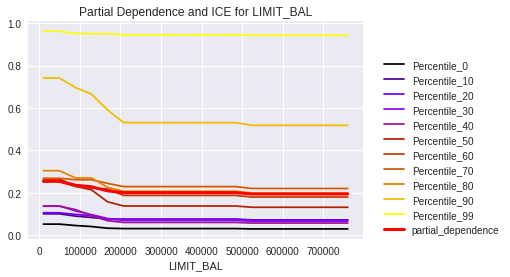

In [46]:
plot_par_dep_ICE('LIMIT_BAL', par_dep_LIMIT_BAL) #Plot partial dependence and ICE for LIMIT_BAL

#### Partial dependence and ICE plot for AGE
Prediction behavior for AGE is displayed for all percentiles of model predictions. Predition behavior is different at different deciles, but not abnormal or vastly different from the average prediction behavior represented by the red partial dependence curve, except for the customer most likely to default. For this high-risk customer, changes in AGE do not have a large impact on their probability of default.

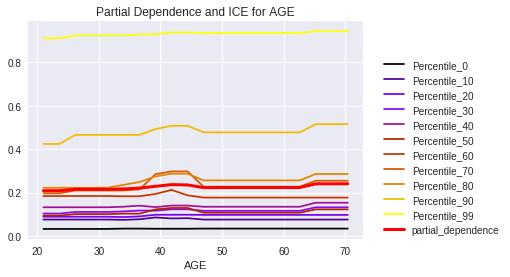

In [47]:
plot_par_dep_ICE('AGE', par_dep_AGE) #Plot partial dependence and ICE for AGE

#### Partial dependence and ICE plot for EDUCATION
Prediction behavior for EDUCATION is also displayed for all percentiles. Overall the prediction behavior is flat across most deciles/global while others appear to show a "bend" in prediction behavior. This "bend" for some deciles might indicate as education increases the probability of default also increases to a certain extent and then tapers off. 

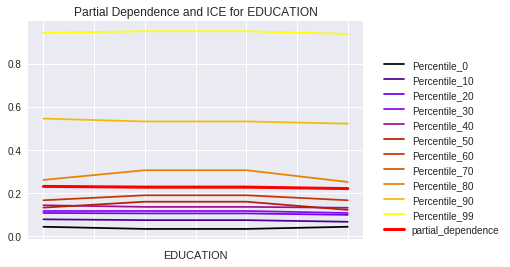

In [48]:
plot_par_dep_ICE('EDUCATION', par_dep_EDUCATION) #Plot partial dependence and ICE for EDUCATION

### Summary
In this notebook, a DAI model was trained to predict credit card defaults and the prediction behavior of the DAI model was analyzed and validated. Partial dependence and ICE were calculated, plotted, and compared to one another, domain knowledge, and reasonable expectations. These techniques should generalize well for many types of business and research problems, enabling you to train a DAI model and analyze, validate, and explain it to your colleagues, bosses, and potentially, external regulators.